In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.datasets import mnist
from keras.utils import np_utils
from scipy import signal
from sklearn.utils import shuffle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # return output
        pass

    def backward(self, output_gradient, learning_rate):
        # update parameters and return input gradient
        pass

class Activation(Layer):
    def __init__(self, activation, activation_derivative):
        self.activation = activation
        self.activation_derivative = activation_derivative

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_derivative(self.input))    

In [3]:
class Linear(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [4]:
def convolve2D(image, kernel, padding=0, strides=1, conv180=False):
    # Cross Correlation to Convolution for Input updates
    if conv180:
        kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Padding to All Sides. Thats needed for "full" convolution 
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit condition
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [5]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)
        self.pad_full = kernel_size - 1
        print(self.pad_full)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += convolve2D(self.input[j], self.kernels[i][j])

        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        
        

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = convolve2D(self.input[j], output_gradient[i])
                input_gradient[j] += convolve2D(output_gradient[i], self.kernels[i, j], padding=self.pad_full, conv180=True)

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [6]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [7]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_derivative(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_derivative)

In [8]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [9]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [10]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_derivative, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    history={"train_loss":[], "train_accuracy":[], "val_loss":[], "val_accuracy":[]}
    for e in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        error = 0
        num_correct = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)
            if np.argmax(output) == np.argmax(y):
                num_correct += 1
            # error
            error += loss(y, output)
           

            # backward
            grad = loss_derivative(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        num_correct /= len(x_train)
        history["train_loss"].append(error)
        history["train_accuracy"].append(num_correct)
        if verbose:
            print(f"epoch {e + 1}/{epochs}, train_loss: {error}") 
            print(f"accuracy on train: {num_correct}")  
        # test
        pr_r = 0
        err = 0
        for x, y in zip(x_test, y_test):
            output = predict(network, x)
            err += loss(y, output)
            
        #     print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
            if np.argmax(output) == np.argmax(y):
                pr_r += 1
        err /= len(x_test)
        pr_r /= len(x_test)
        history["val_loss"].append(err)
        history["val_accuracy"].append(pr_r)
        print(f"loss on val: {err}") 
        print(f"accuracy on val: {pr_r}")
    return history

In [11]:
def preprocess_data(x, y, limit):
    indices = []
    for i in range(10): 
        current = np.where(y==i)[0][:limit]
        indices.append(current)
        
    all_indices = np.hstack((indices[0],indices[1],indices[2],indices[3],indices[4],indices[5],indices[6],indices[7],indices[8],indices[9]))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
#     print(y)
    y = y.reshape(len(y), 10, 1)
    return x, y
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 300)
x_test, y_test = preprocess_data(x_test, y_test, 100)
# print(len(x_test))
# print(len(y_test))

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),  # one-channel image 28x28, 3x3 kernel, depth 5
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Linear(5 * 26 * 26, 100),
    Sigmoid(),
    Linear(100, 10),
    Sigmoid()
]




# train
history = train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_derivative,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

      
        
    

11501568/11490434 [==============================] - 0s 0us/step
2
epoch 1/20, train_loss: 0.32394529258225446
accuracy on train: 0.24
loss on val: 0.2907984765698447
accuracy on val: 0.314
epoch 2/20, train_loss: 0.26338956427080057
accuracy on train: 0.4023333333333333
loss on val: 0.25951953456144067
accuracy on val: 0.424
epoch 3/20, train_loss: 0.2253843179394851
accuracy on train: 0.5196666666666667
loss on val: 0.22004048567514856
accuracy on val: 0.506
epoch 4/20, train_loss: 0.19570445116736043
accuracy on train: 0.5916666666666667
loss on val: 0.20712054307076275
accuracy on val: 0.568
epoch 5/20, train_loss: 0.1786795415018753
accuracy on train: 0.648
loss on val: 0.18943484800000948
accuracy on val: 0.615
epoch 6/20, train_loss: 0.16409314294764765
accuracy on train: 0.6856666666666666
loss on val: 0.16869147234867776
accuracy on val: 0.67
epoch 7/20, train_loss: 0.15400740951158762
accuracy on train: 0.71
loss on val: 0.16251899756544183
accuracy on val: 0.658
epoch 8/20, 

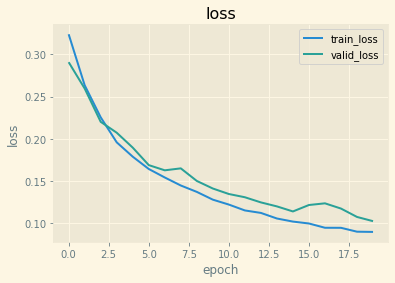

In [12]:
import matplotlib.pyplot as plt 
plt.style.use('Solarize_Light2')
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="valid_loss")
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='upper right')


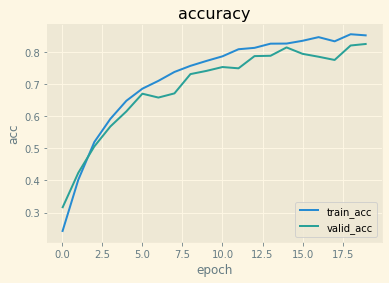

In [13]:
import matplotlib.pyplot as plt 
plt.style.use('Solarize_Light2')
plt.figure()
plt.plot(history["train_accuracy"], label="train_acc")
plt.plot(history["val_accuracy"], label="valid_acc")
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend(loc='lower right')
